In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import rasterio
import numpy as np
import torch.nn as nn
import torch.optim as optim
from skimage.transform import resize
from tqdm import tqdm
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import geometry_mask
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.set_per_process_memory_fraction(0.8, 0)

tif_path = "G:/16_ECMWF/7_climate_10_520_400/1_tem/2017/tem_2017_01_01.tif"
with rasterio.open(tif_path) as src:
        image_data = src.read(1)  # 读取第一个波段
        transform = src.transform
        crs = src.crs
        bounds = src.bounds
        height, width = src.height, src.width
        profile = src.profile  # 获取文件元数据以便后续导出
    
shp_path = "C:/Users/Administrator/Desktop/边界/九大农业区/Agr_qu.shp"
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(crs)
geometries = [mapping(geometry) for geometry in shapefile.geometry]
mask = geometry_mask(geometries, transform=transform, invert=True, out_shape=(height, width))

Using device: cuda


In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, tem_dirs, tem_min_dirs, tem_max_dirs, pr_dirs, wind_dirs, ps_dirs, solar_dirs, ther_dirs, rh_dirs, eva_dirs, transform=None):
        self.tem_files = self._get_all_files(tem_dirs)
        self.tem_min_files = self._get_all_files(tem_min_dirs)
        self.tem_max_files = self._get_all_files(tem_max_dirs)
        self.pr_files = self._get_all_files(pr_dirs)
        self.wind_files = self._get_all_files(wind_dirs)
        self.ps_files = self._get_all_files(ps_dirs)
        self.solar_files = self._get_all_files(solar_dirs)
        self.ther_files = self._get_all_files(ther_dirs)
        self.rh_files = self._get_all_files(rh_dirs)
        self.eva_files = self._get_all_files(eva_dirs)
        
        self.transform = transform

    def _get_all_files(self, dirs):
        all_files = []
        for directory in dirs:
            for filename in sorted(os.listdir(directory)):  # 排序保证匹配
                file_path = os.path.join(directory, filename)
                if os.path.isfile(file_path):  # 确保是文件
                    all_files.append(file_path)
        return all_files

    def __len__(self):
        return len(self.tem_files)

    def __getitem__(self, idx):
        tem_path = self.tem_files[idx]
        tem_min_path = self.tem_min_files[idx]
        tem_max_path = self.tem_max_files[idx]
        pr_path = self.pr_files[idx]
        wind_path = self.wind_files[idx]
        ps_path = self.ps_files[idx]
        solar_path = self.solar_files[idx]
        ther_path = self.ther_files[idx]
        rh_path = self.rh_files[idx]
        eva_path = self.eva_files[idx]
        
        with rasterio.open(tem_path) as tem_dataset:
            tem_image = tem_dataset.read(1)  
        with rasterio.open(tem_min_path) as tem_min_dataset:
            tem_min_image = tem_min_dataset.read(1)  
        with rasterio.open(tem_max_path) as tem_max_dataset:
            tem_max_image = tem_max_dataset.read(1)  
        with rasterio.open(pr_path) as pr_dataset:
            pr_image = pr_dataset.read(1)
            pr_image = pr_image*1000
        with rasterio.open(wind_path) as wind_dataset:
            wind_image = wind_dataset.read(1)  
        with rasterio.open(ps_path) as ps_dataset:
            ps_image = ps_dataset.read(1)  
            ps_image = ps_image/1000
        with rasterio.open(solar_path) as solar_dataset:
            solar_image = solar_dataset.read(1) 
            solar_image = solar_image/86400
        with rasterio.open(ther_path) as ther_dataset:
            ther_image = ther_dataset.read(1) 
            ther_image = ther_image/86400
        with rasterio.open(rh_path) as rh_dataset:
            rh_image = rh_dataset.read(1) 
        with rasterio.open(eva_path) as eva_dataset:
            eva_image = eva_dataset.read(1) 

        # 如果有 transform，应用转换
        if self.transform:
            tem_image = self.transform(tem_image)
            tem_min_image = self.transform(tem_min_image)
            tem_max_image = self.transform(tem_max_image)
            pr_image = self.transform(pr_image)
            wind_image = self.transform(wind_image)
            ps_image = self.transform(ps_image)
            solar_image = self.transform(solar_image)
            ther_image = self.transform(ther_image)
            rh_image = self.transform(rh_image)
            eva_image = self.transform(eva_image)

        else:
        # 如果没有 transform，转换为 PyTorch 张量
            tem_image = torch.from_numpy(tem_image).float()  # (1, H, W)
            tem_min_image = torch.from_numpy(tem_min_image).float()  # (1, H, W)
            tem_max_image = torch.from_numpy(tem_max_image).float()  # (1, H, W)
            pr_image = torch.from_numpy(pr_image).float()  # (1, H, W)
            wind_image = torch.from_numpy(wind_image).float()  # (1, H, W)
            ps_image = torch.from_numpy(ps_image).float()  # (1, H, W)
            solar_image = torch.from_numpy(solar_image).float()  # (1, H, W)
            ther_image = torch.from_numpy(ther_image).float()  # (1, H, W)
            rh_image = torch.from_numpy(rh_image).float()  # (1, H, W)
            eva_image = torch.from_numpy(eva_image).float()  # (1, H, W)

        lr_image =  torch.cat([tem_image, tem_min_image,tem_max_image,pr_image,wind_image,ps_image,solar_image,ther_image,rh_image], dim=0)
            
        return lr_image, eva_image
# 定义数据增强和预处理操作
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # 将 NumPy 数组转换为 PyTorch 张量
])

def load_tiff_with_rasterio(file_path):
    with rasterio.open(file_path) as src:
        img = src.read(1)  # 读取第一个波段
        img = img
    return img

In [4]:
year = list(range(2000,2014))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_train = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0)


year = list(range(2014,2019))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_val = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_val = DataLoader(dataset_val, batch_size=16, shuffle=True, num_workers=0)


year = list(range(2019,2024))
tem_directories = []
tem_min_directories = []
tem_max_directories = []
pr_directories = []
wind_directories = []
ps_directories = []
solar_directories = []
ther_directories = []
rh_directories = []
eva_directories = []
for a_index,a in enumerate(year):
    tem_path = f'F:/3_climate_100_52_40/1_tem/{a}'
    tem_directories.append(tem_path)
    tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}'
    tem_min_directories.append(tem_min_path)
    tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}'
    tem_max_directories.append(tem_max_path)
    pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}'
    pr_directories.append(pr_path)
    wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}'
    wind_directories.append(wind_path)
    ps_path = f'F:/3_climate_100_52_40/6_ps/{a}'
    ps_directories.append(ps_path)
    solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}'
    solar_directories.append(solar_path)
    ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}'
    ther_directories.append(ther_path)
    rh_path = f'F:/3_climate_100_52_40/11_rh/{a}'
    rh_directories.append(rh_path)
    eva_path = f'D:/7_climate_10_520_400/12_PET/{a}'
    eva_directories.append(eva_path)
dataset_test = SuperResolutionDataset(tem_dirs = tem_directories, tem_min_dirs = tem_min_directories, tem_max_dirs = tem_max_directories, 
                                       pr_dirs = pr_directories, wind_dirs = wind_directories, ps_dirs = ps_directories, solar_dirs = solar_directories,
                                       ther_dirs = ther_directories, rh_dirs = rh_directories, eva_dirs = eva_directories, transform=data_transforms)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=0)

In [5]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader):
        inputs  = inputs.float().to(device)
        targets = targets.float().to(device)

        inputs[torch.isnan(inputs)] = 0
        targets[torch.isnan(targets)] = 0

        assert not torch.isnan(inputs).any(), "Input contains NaN values"
        assert not torch.isnan(targets).any(), "Target contains NaN values"
        
        optimizer.zero_grad()
        outputs = nn.functional.interpolate(inputs, size=(400, 520), mode='bilinear', align_corners=False)
        outputs_up = model(outputs)

        loss = criterion(outputs_up, targets).to(device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs = inputs.float().to(device)
            targets =  targets.float().to(device)
            inputs[torch.isnan(inputs)] = 0
            targets[torch.isnan(targets)] = 0

            outputs = nn.functional.interpolate(inputs, size=(400, 520), mode='bilinear', align_corners=False)
            
            outputs = model(outputs)

            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


In [6]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(9, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SRCNN().to(device)

learning_rate = 0.0001
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)

num_epochs = 100
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Model is training on: {next(model.parameters()).device}')
    train_loss = train_model(model, dataloader_train, criterion, optimizer, device)
    val_loss = validate_model(model, dataloader_val, criterion, device)
    print(f'Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/SRCNN_pet.pth')
        print('Model saved!')


cuda
Epoch 1/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:14<00:00,  1.54it/s]


Train Loss: 0.8596 | Validation Loss: 0.4433
Model saved!
Epoch 2/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.67it/s]


Train Loss: 0.4537 | Validation Loss: 0.4040
Model saved!
Epoch 3/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Train Loss: 0.4345 | Validation Loss: 0.3959
Model saved!
Epoch 4/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:06<00:00,  1.73it/s]


Train Loss: 0.4201 | Validation Loss: 0.4192
Epoch 5/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


Train Loss: 0.4142 | Validation Loss: 0.3940
Model saved!
Epoch 6/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


Train Loss: 0.4030 | Validation Loss: 0.3983
Epoch 7/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.64it/s]


Train Loss: 0.3967 | Validation Loss: 0.3821
Model saved!
Epoch 8/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.64it/s]


Train Loss: 0.3941 | Validation Loss: 0.3955
Epoch 9/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.62it/s]


Train Loss: 0.3903 | Validation Loss: 0.3774
Model saved!
Epoch 10/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


Train Loss: 0.3865 | Validation Loss: 0.3702
Model saved!
Epoch 11/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.65it/s]


Train Loss: 0.3812 | Validation Loss: 0.3669
Model saved!
Epoch 12/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Train Loss: 0.3786 | Validation Loss: 0.3814
Epoch 13/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3790 | Validation Loss: 0.3840
Epoch 14/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


Train Loss: 0.3736 | Validation Loss: 0.3706
Epoch 15/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


Train Loss: 0.3751 | Validation Loss: 0.3930
Epoch 16/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3728 | Validation Loss: 0.3693
Epoch 17/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.64it/s]


Train Loss: 0.3673 | Validation Loss: 0.3797
Epoch 18/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.66it/s]


Train Loss: 0.3685 | Validation Loss: 0.3640
Model saved!
Epoch 19/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.63it/s]


Train Loss: 0.3632 | Validation Loss: 0.3676
Epoch 20/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3617 | Validation Loss: 0.3513
Model saved!
Epoch 21/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.67it/s]


Train Loss: 0.3579 | Validation Loss: 0.3591
Epoch 22/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.63it/s]


Train Loss: 0.3610 | Validation Loss: 0.3440
Model saved!
Epoch 23/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.65it/s]


Train Loss: 0.3571 | Validation Loss: 0.3479
Epoch 24/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:12<00:00,  1.59it/s]


Train Loss: 0.3553 | Validation Loss: 0.3420
Model saved!
Epoch 25/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:12<00:00,  1.59it/s]


Train Loss: 0.3539 | Validation Loss: 0.3395
Model saved!
Epoch 26/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:11<00:00,  1.62it/s]


Train Loss: 0.3542 | Validation Loss: 0.3456
Epoch 27/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:09<00:00,  1.67it/s]


Train Loss: 0.3490 | Validation Loss: 0.3434
Epoch 28/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:10<00:00,  1.64it/s]


Train Loss: 0.3521 | Validation Loss: 0.3542
Epoch 29/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:11<00:00,  1.61it/s]


Train Loss: 0.3531 | Validation Loss: 0.3547
Epoch 30/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3517 | Validation Loss: 0.3475
Epoch 31/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3477 | Validation Loss: 0.3557
Epoch 32/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3456 | Validation Loss: 0.3405
Epoch 33/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3476 | Validation Loss: 0.3343
Model saved!
Epoch 34/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3422 | Validation Loss: 0.3427
Epoch 35/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3415 | Validation Loss: 0.3323
Model saved!
Epoch 36/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3432 | Validation Loss: 0.3382
Epoch 37/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3416 | Validation Loss: 0.3558
Epoch 38/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.72it/s]


Train Loss: 0.3435 | Validation Loss: 0.3375
Epoch 39/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3384 | Validation Loss: 0.3317
Model saved!
Epoch 40/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.67it/s]


Train Loss: 0.3428 | Validation Loss: 0.3289
Model saved!
Epoch 41/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3387 | Validation Loss: 0.3328
Epoch 42/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3380 | Validation Loss: 0.3279
Model saved!
Epoch 43/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3383 | Validation Loss: 0.3278
Model saved!
Epoch 44/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3369 | Validation Loss: 0.3284
Epoch 45/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3346 | Validation Loss: 0.3318
Epoch 46/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3393 | Validation Loss: 0.3241
Model saved!
Epoch 47/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3341 | Validation Loss: 0.3280
Epoch 48/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3336 | Validation Loss: 0.3264
Epoch 49/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3347 | Validation Loss: 0.3436
Epoch 50/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3341 | Validation Loss: 0.3277
Epoch 51/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3323 | Validation Loss: 0.3233
Model saved!
Epoch 52/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3335 | Validation Loss: 0.3402
Epoch 53/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3347 | Validation Loss: 0.3222
Model saved!
Epoch 54/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3333 | Validation Loss: 0.3359
Epoch 55/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3308 | Validation Loss: 0.3222
Epoch 56/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3308 | Validation Loss: 0.3235
Epoch 57/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3296 | Validation Loss: 0.3243
Epoch 58/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3309 | Validation Loss: 0.3310
Epoch 59/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3301 | Validation Loss: 0.3186
Model saved!
Epoch 60/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3310 | Validation Loss: 0.3217
Epoch 61/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3281 | Validation Loss: 0.3243
Epoch 62/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3289 | Validation Loss: 0.3223
Epoch 63/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3281 | Validation Loss: 0.3206
Epoch 64/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3281 | Validation Loss: 0.3220
Epoch 65/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3257 | Validation Loss: 0.3180
Model saved!
Epoch 66/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3275 | Validation Loss: 0.3481
Epoch 67/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3265 | Validation Loss: 0.3229
Epoch 68/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3257 | Validation Loss: 0.3349
Epoch 69/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3286 | Validation Loss: 0.3461
Epoch 70/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3274 | Validation Loss: 0.3308
Epoch 71/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3231 | Validation Loss: 0.3214
Epoch 72/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3248 | Validation Loss: 0.3192
Epoch 73/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3233 | Validation Loss: 0.3259
Epoch 74/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3260 | Validation Loss: 0.3213
Epoch 75/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3250 | Validation Loss: 0.3368
Epoch 76/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3224 | Validation Loss: 0.3282
Epoch 77/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3231 | Validation Loss: 0.3140
Model saved!
Epoch 78/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3239 | Validation Loss: 0.3185
Epoch 79/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3274 | Validation Loss: 0.3147
Epoch 80/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3255 | Validation Loss: 0.3163
Epoch 81/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3208 | Validation Loss: 0.3164
Epoch 82/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


Train Loss: 0.3222 | Validation Loss: 0.3103
Model saved!
Epoch 83/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3209 | Validation Loss: 0.3231
Epoch 84/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3242 | Validation Loss: 0.3119
Epoch 85/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3203 | Validation Loss: 0.3122
Epoch 86/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.69it/s]


Train Loss: 0.3208 | Validation Loss: 0.3116
Epoch 87/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3219 | Validation Loss: 0.3184
Epoch 88/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3231 | Validation Loss: 0.3140
Epoch 89/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3183 | Validation Loss: 0.3461
Epoch 90/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3196 | Validation Loss: 0.3496
Epoch 91/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3232 | Validation Loss: 0.3122
Epoch 92/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:08<00:00,  1.68it/s]


Train Loss: 0.3197 | Validation Loss: 0.3520
Epoch 93/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3222 | Validation Loss: 0.3096
Model saved!
Epoch 94/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3185 | Validation Loss: 0.3167
Epoch 95/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3196 | Validation Loss: 0.3080
Model saved!
Epoch 96/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3204 | Validation Loss: 0.3186
Epoch 97/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]


Train Loss: 0.3185 | Validation Loss: 0.3129
Epoch 98/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.71it/s]


Train Loss: 0.3210 | Validation Loss: 0.3378
Epoch 99/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.69it/s]


Train Loss: 0.3183 | Validation Loss: 0.3102
Epoch 100/100
Model is training on: cuda:0


100%|██████████| 115/115 [01:07<00:00,  1.70it/s]

Train Loss: 0.3170 | Validation Loss: 0.3156


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4328\2562409661.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_m

torch.Size([1, 9, 40, 52])


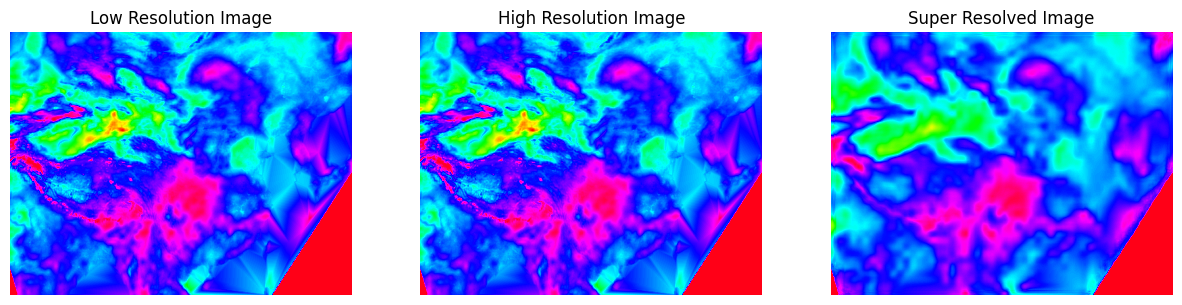

In [9]:
model = SRCNN().to(device)
model.load_state_dict(torch.load('G:/16_ECMWF/13_DL_modle/1_climate_520_400/13_pet/SRCNN_pet.pth'))
model.eval()  # 设置为评估模式

eva_image_path = 'D:/7_climate_10_520_400/12_PET/2020/PET_2020_07_01.tif'
tem_image_path = 'F:/3_climate_100_52_40/1_tem/2020/tem_2020_07_01.tif'
tem_min_image_path = 'F:/3_climate_100_52_40/3_tem_min/2020/tem_min_2020_07_01.tif'
tem_max_image_path = 'F:/3_climate_100_52_40/2_tem_max/2020/tem_max_2020_07_01.tif'
pr_image_path = 'F:/3_climate_100_52_40/7_tol_per/2020/per_2020_07_01.tif'
wind_image_path = 'F:/3_climate_100_52_40/4_wind_u/2020/wind_2020_07_01.tif'
ps_image_path = 'F:/3_climate_100_52_40/6_ps/2020/ps_2020_07_01.tif'
solar_image_path = 'F:/3_climate_100_52_40/8_solar_rad/2020/solar_rad_2020_07_01.tif'
ther_image_path = 'F:/3_climate_100_52_40/9_ther_rad/2020/ther_rad_2020_07_01.tif'
rh_image_path = 'F:/3_climate_100_52_40/11_rh/2020/rh_2020_07_01.tif'
eva_image = load_tiff_with_rasterio(eva_image_path)
tem_image = load_tiff_with_rasterio(tem_image_path)
tem_min_image = load_tiff_with_rasterio(tem_min_image_path)
tem_max_image = load_tiff_with_rasterio(tem_max_image_path)
pr_image = load_tiff_with_rasterio(pr_image_path)
pr_image = pr_image*1000
wind_image = load_tiff_with_rasterio(wind_image_path)
ps_image = load_tiff_with_rasterio(ps_image_path)
ps_image = ps_image/1000
solar_image = load_tiff_with_rasterio(solar_image_path)
solar_image = solar_image/86400
ther_image = load_tiff_with_rasterio(ther_image_path)
ther_image = ther_image/86400
rh_image = load_tiff_with_rasterio(rh_image_path)

transform = transforms.ToTensor()
tem_tensor = transform(tem_image).unsqueeze(0)
tem_min_tensor = transform(tem_min_image).unsqueeze(0)
tem_max_tensor = transform(tem_max_image).unsqueeze(0)
pr_tensor = transform(pr_image).unsqueeze(0)
wind_tensor = transform(wind_image).unsqueeze(0)
ps_tensor = transform(ps_image).unsqueeze(0)
solar_tensor = transform(solar_image).unsqueeze(0)
ther_tensor = transform(ther_image).unsqueeze(0)
rh_tensor = transform(rh_image).unsqueeze(0)

lr_tensor= torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
print(lr_tensor.shape)
lr_tensor = lr_tensor.float().to(device)

vmin = eva_image[mask].min()
vmax = eva_image[mask].max()

model.to(device)
with torch.no_grad():
    lr_tensor = nn.functional.interpolate(lr_tensor, size=(400, 520), mode='bilinear', align_corners=False)
    sr_tensor = model(lr_tensor)
sr_image = sr_tensor.squeeze().cpu().numpy()

def plot_images(lr_image, hr_image, sr_image):


    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(lr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Low Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(hr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('High Resolution Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(sr_image, cmap='hsv_r', vmin=vmin, vmax=vmax)  # 限制值范围在240-300
    plt.title('Super Resolved Image')
    plt.axis('off')

    plt.show()
plot_images(eva_image, eva_image, sr_image)

In [10]:
with rasterio.open(eva_image_path) as src:
    # 获取原始图像的地理信息（仿射变换矩阵和投影坐标系）
    transform = src.transform
    crs = src.crs
    profile = src.profile
profile.update(
    dtype=rasterio.float32,   # 数据类型为 float32
    count=1,                  # 1 个波段
    height=sr_image.shape[0], # 高度
    width=sr_image.shape[1],  # 宽度
    transform=transform        # 保持原始的地理变换信息
)

year = list(range(2000, 2024))
model.to(device)
transform = transforms.ToTensor()
for a_index, a in enumerate(year):
    start_date = f'{a}-01-01'
    end_date = f'{a}-12-31'
    date_range = pd.date_range(start=start_date, end=end_date)
    print(a)
    for b_index, b in enumerate(date_range):
        day_index = b_index
        date_day = date_range[day_index]
        date_day_year = date_day.year
        date_day_month = date_day.month
        date_day_day = date_day.day
        tem_path = f'F:/3_climate_100_52_40/1_tem/{a}/tem_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_min_path = f'F:/3_climate_100_52_40/3_tem_min/{a}/tem_min_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        tem_max_path = f'F:/3_climate_100_52_40/2_tem_max/{a}/tem_max_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        pr_path = f'F:/3_climate_100_52_40/7_tol_per/{a}/per_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        wind_path = f'F:/3_climate_100_52_40/4_wind_u/{a}/wind_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ps_path = f'F:/3_climate_100_52_40/6_ps/{a}/ps_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        solar_path = f'F:/3_climate_100_52_40/8_solar_rad/{a}/solar_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        ther_path = f'F:/3_climate_100_52_40/9_ther_rad/{a}/ther_rad_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        rh_path = f'F:/3_climate_100_52_40/11_rh/{a}/rh_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        
        output_path = f'J:/3_climate_output/1_climate_520_400/3_SRCNN/12_pet/{a}/pet_{date_day_year}_{date_day_month:02d}_{date_day_day:02d}.tif'
        
        tem_image = load_tiff_with_rasterio(tem_path)
        tem_tensor = transform(tem_image).unsqueeze(0) 
        tem_tensor = tem_tensor.float().to(device)
        
        tem_min_image = load_tiff_with_rasterio(tem_min_path)
        tem_min_tensor = transform(tem_min_image).unsqueeze(0) 
        tem_min_tensor = tem_min_tensor.float().to(device)

        tem_max_image = load_tiff_with_rasterio(tem_max_path)
        tem_max_tensor = transform(tem_max_image).unsqueeze(0) 
        tem_max_tensor = tem_max_tensor.float().to(device)

        pr_image = load_tiff_with_rasterio(pr_path)
        pr_image = pr_image*1000
        pr_tensor = transform(pr_image).unsqueeze(0) 
        pr_tensor = pr_tensor.float().to(device)

        ps_image = load_tiff_with_rasterio(ps_path)
        ps_image = ps_image/1000
        ps_tensor = transform(ps_image).unsqueeze(0) 
        ps_tensor = ps_tensor.float().to(device)

        wind_image = load_tiff_with_rasterio(wind_path)
        wind_tensor = transform(wind_image).unsqueeze(0) 
        wind_tensor = wind_tensor.float().to(device)

        solar_image = load_tiff_with_rasterio(solar_path)
        solar_image = solar_image/86400
        solar_tensor = transform(solar_image).unsqueeze(0) 
        solar_tensor = solar_tensor.float().to(device)

        ther_image = load_tiff_with_rasterio(ther_path)
        ther_image = ther_image/86400
        ther_tensor = transform(ther_image).unsqueeze(0) 
        ther_tensor = ther_tensor.float().to(device)

        rh_image = load_tiff_with_rasterio(rh_path)
        rh_tensor = transform(rh_image).unsqueeze(0) 
        rh_tensor = rh_tensor.float().to(device)
    

        lr_tensor = torch.cat([tem_tensor,tem_min_tensor,tem_max_tensor,pr_tensor,wind_tensor,ps_tensor,solar_tensor,ther_tensor,rh_tensor],dim=1)
        
        with torch.no_grad():
            outputs = nn.functional.interpolate(lr_tensor, size=(400, 520), mode='bilinear', align_corners=False)
            sr_tensor = model(outputs)
        sr_image = sr_tensor.squeeze().cpu().numpy()
        
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(sr_image.astype(rasterio.float32), 1)  # 将 sr_image 写入为第一个波段

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
